## Combining Spectra 

In [1]:
from muler.hpf import HPFSpectrum, HPFSpectrumList
import numpy as np
import glob
from pylab import*

%config InlineBackend.figure_format='retina'

##Read in each file for the different observations. All the data analysis can also be performed on each observation, but make sure the correct RV is used of the star in order to correctly shift the spectrum. 

In [21]:
local_files = glob.glob("../../src/tests/data/Slope-20191227T061633_R01_0011.optimal.fits")
file = local_files[0]

original_spectrum = HPFSpectrum(file=file, order=19) #reading in file

k2_100RV = 34786.4 # in m/s from Simbad

shifted_spectrum = original_spectrum.normalize().sky_subtract().remove_nans().blaze_divide_spline().shift_spec(k2_100RV)

In [22]:
local_files = glob.glob("../../src/tests/data/Slope-20191227T062631_R01_0012.optimal.fits")
file = local_files[0]

original_spectrum_2 = HPFSpectrum(file=file, order=19) 


shifted_spectrum_2 = original_spectrum_2.normalize().sky_subtract().remove_nans().blaze_divide_spline().shift_spec(k2_100RV)

In [23]:
local_files = glob.glob("../../src/tests/data/Slope-20191227T063628_R01_0013.optimal.fits")
file = local_files[0]

original_spectrum_3 = HPFSpectrum(file=file, order=19) 


shifted_spectrum_3 = original_spectrum_3.normalize().sky_subtract().remove_nans().blaze_divide_spline().shift_spec(k2_100RV)

In [24]:
local_files = glob.glob("../../src/tests/data/Slope-20191227T064625_R01_0014.optimal.fits")
file = local_files[0]

original_spectrum_4 = HPFSpectrum(file=file, order=19) 


shifted_spectrum_4 = original_spectrum_4.normalize().sky_subtract().remove_nans().blaze_divide_spline().shift_spec(k2_100RV)

In [25]:
local_files = glob.glob("../../src/tests/data/Slope-20191227T065622_R01_0015.optimal.fits")
file = local_files[0]

original_spectrum_5 = HPFSpectrum(file=file, order=19) 


shifted_spectrum_5 = original_spectrum_5.normalize().sky_subtract().remove_nans().blaze_divide_spline().shift_spec(k2_100RV)

In [26]:
local_files = glob.glob("../../src/tests/data/Slope-20191227T070619_R01_0016.optimal.fits")
file = local_files[0]

original_spectrum_6 = HPFSpectrum(file=file, order=19) 


shifted_spectrum_6 = original_spectrum_6.normalize().sky_subtract().remove_nans().blaze_divide_spline().shift_spec(k2_100RV)

Can create a plot of the newly created spectras in order to double check that the files are reading in correctly.

(10830.0, 10840.0)

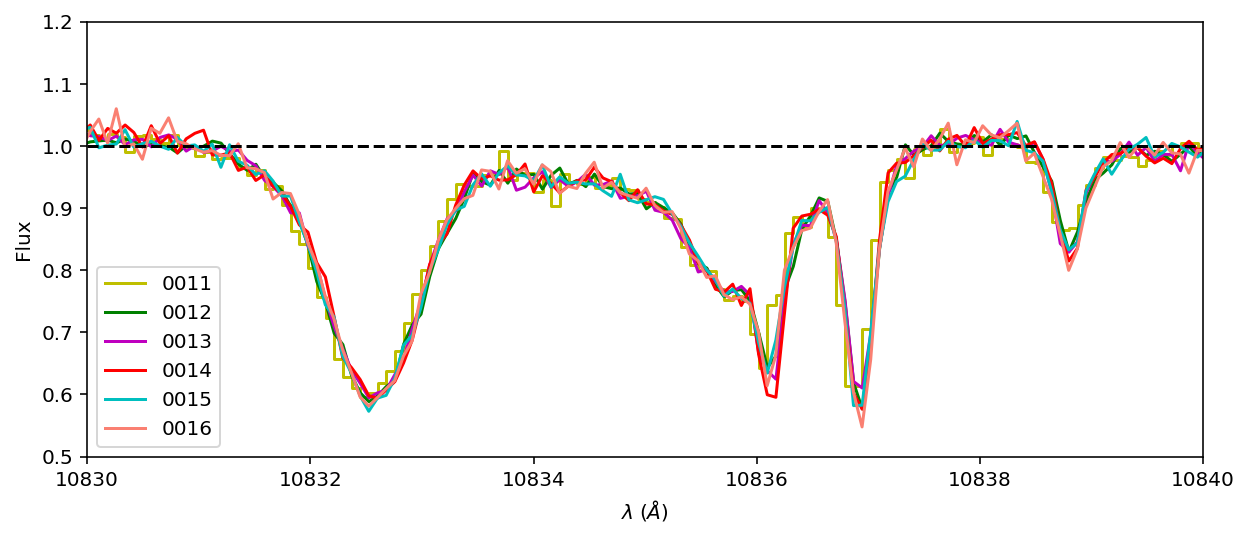

In [27]:
ax = shifted_spectrum.normalize().plot(label='0011', color='y')
# The number labels represent the name of the data files for each observation
plot(shifted_spectrum_2.normalize().wavelength, shifted_spectrum_2.normalize().flux, label='0012', color='g')
plot(shifted_spectrum_3.normalize().wavelength, shifted_spectrum_3.normalize().flux, label='0013', color='m')
plot(shifted_spectrum_4.normalize().wavelength, shifted_spectrum_4.normalize().flux, label='0014', color='r')
plot(shifted_spectrum_5.normalize().wavelength, shifted_spectrum_5.normalize().flux, label='0015', color='c')
plot(shifted_spectrum_6.normalize().wavelength, shifted_spectrum_6.normalize().flux, label='0016', color='salmon')

ax.axhline(1.0, linestyle='dashed', color='k')
ax.set_ylim(0.5, 1.2); ax.legend();
ax.set_xlim(10830,10840)

The plot reveals that all the files are successfully read in, and the next step is to combine all the observations into one combined spectrum. The first step is to resample all of the spectras with respect to the first spectra. 

In [28]:
from specutils import Spectrum1D
import numpy as np
from astropy.nddata import StdDevUncertainty
import astropy.units as u
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In [29]:
from specutils.manipulation import FluxConservingResampler, LinearInterpolatedResampler

In [30]:
resampler = FluxConservingResampler(extrapolation_treatment='nan_fill')

In [31]:
%%capture
#This method throws a warning for an unknown reason...
resampled_shifted_spectrum_2 = resampler(shifted_spectrum_2, shifted_spectrum.spectral_axis)
resampled_shifted_spectrum_3 = resampler(shifted_spectrum_3, shifted_spectrum.spectral_axis)
resampled_shifted_spectrum_4 = resampler(shifted_spectrum_4, shifted_spectrum.spectral_axis)
resampled_shifted_spectrum_5 = resampler(shifted_spectrum_5, shifted_spectrum.spectral_axis)
resampled_shifted_spectrum_6 = resampler(shifted_spectrum_6, shifted_spectrum.spectral_axis)

#resamples spectrum with respect to the first one

The function used for combining the spectras utilizes a list, and that list is simply all the observations that need to be combined. Starting with the first shifted spectrum, and then followed by all the resampled spectras. 

In [32]:
spec_list= [shifted_spectrum, resampled_shifted_spectrum_2, resampled_shifted_spectrum_3, resampled_shifted_spectrum_4, resampled_shifted_spectrum_5, resampled_shifted_spectrum_6]

Now the combining function can be implemented with the defined list. 

In [33]:
# function for combining spectra
def combine_spectra (spec_list):
    spec_final = spec_list[0]
    for i in range(len(spec_list)-1):
        if i != len(spec_list)-1: 
            new_sigma = np.sqrt(1/spec_list[i+1].uncertainty.array) 
            spec_list[i+1].uncertainty = StdDevUncertainty(new_sigma)
            spec_final = spec_final.add(spec_list[i+1], propagate_uncertainties=True)
    return (spec_final)

DO NOT RUN THIS SECTION OF CODE TWICE!! Due to how the errors combine, if this were to be rerun, the errors bars completely get messed up!

In [34]:
new_spectra = combine_spectra(spec_list) #be careful to not rerun the spectra combination!!!
print(new_spectra)

Spectrum1D (length=2040)
flux:             [ 6.4019, ..., nan ],  mean=nan
spectral axis:    [ 1.0823e+04 Angstrom, ..., 1.0961e+04 Angstrom ],  mean=1.0896e+04 Angstrom
uncertainty:      [ StdDevUncertainty(0.00576649), ..., StdDevUncertainty(nan) ]


The above cell can have the same effect on messing up the erros if it is also ran twice!

(10825.0, 10840.0)

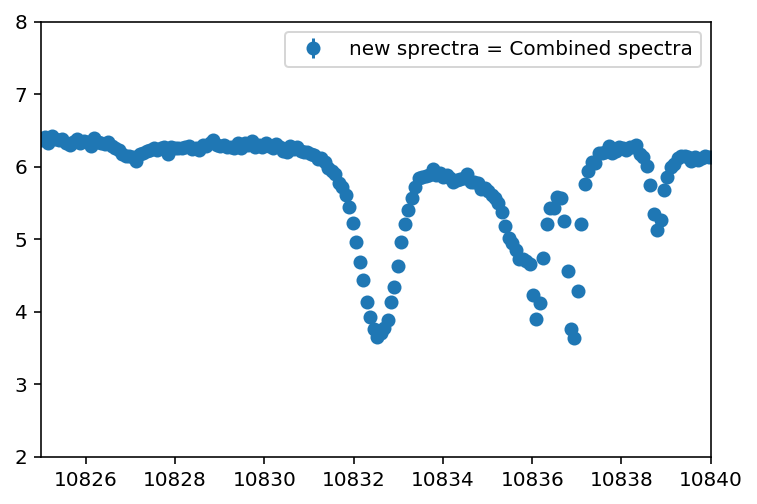

In [36]:
plt.errorbar(new_spectra.wavelength.value, new_spectra.flux.value, yerr=new_spectra.uncertainty.array,
             linestyle='none', marker='o', label='new sprectra = Combined spectra')


plt.legend(loc='best')
plt.ylim(2, 8)
plt.xlim(10825,10840)